In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.data import utils, stamp_correction
from sleeprnn.helpers import reader, plotter, printer, misc, performer

%matplotlib inline
viz.notebook_full_width()

In [2]:
dataset_name = constants.MASS_SS_NAME
fs = 200
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [ ]:
subject_id = 5
signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
hypno = dataset.get_subject_hypnogram(subject_id)
stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)

nrem_pages = [(p in ["1", "2", "3", "4"]) for p in hypno]
n2_pages = [(p in ["2"]) for p in hypno]
print("Number of events: %d" % len(stamps))
print("Number of N2 epochs: %d (%1.2f %% of NREM)" % (np.sum(n2_pages), 100*np.sum(n2_pages)/np.sum(nrem_pages)))

# Spindle parameters

In [22]:
def analyze_spindle(spindle, fs):
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    central_freq_count = find_peaks(spindle)[0].size / duration
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'pp_amplitude': pp_amplitude,
        'rms': rms,
        # 'central_freq_count': central_freq_count,
        'central_freq_fft': central_freq_fft
    }
    return results


def listify_dictionaries(list_of_dicts):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
    return dict_of_lists

In [23]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    sigma_signal = utils.broad_filter(signal, fs, lowcut=9, highcut=17)
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for spindle in spindles:
        analysis_results = analyze_spindle(spindle, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

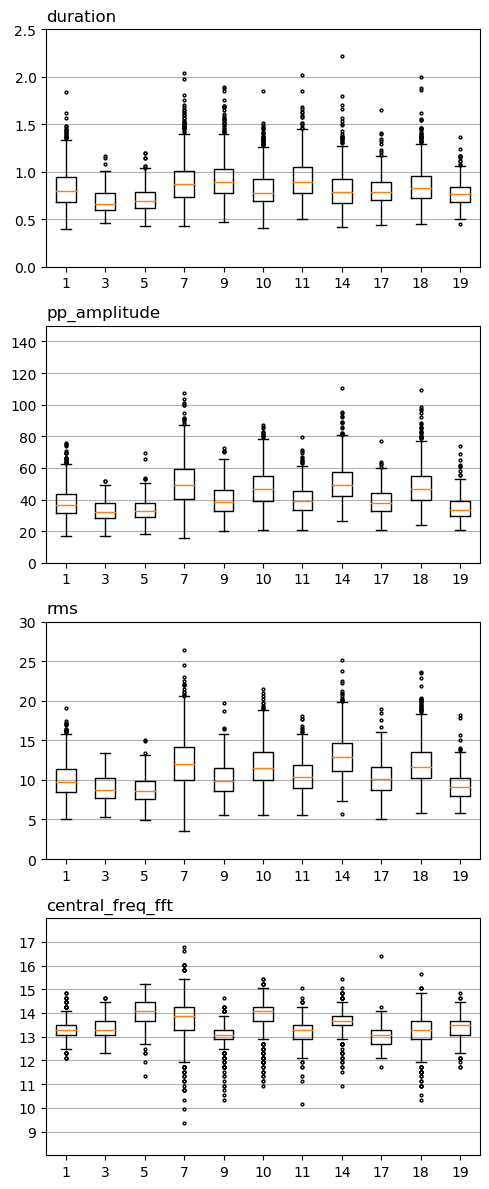

In [30]:
n_keys = len(train_analysis[0].keys())
fig, axes = plt.subplots(n_keys, 1, figsize=(5, 3 * n_keys), dpi=100)
axes_lims = {
    'duration': [0, 2.5],
    'pp_amplitude': [0, 150],
    'rms': [0, 30],
    'central_freq_count': [8, 18],
    'central_freq_fft': [8, 18]
}
for ax, key in zip(axes, train_analysis[0].keys()):
    ax.set_title(key, loc="left")
    ax.boxplot(
        [analysis[key] for analysis in train_analysis], 
        labels=dataset.train_ids,
        flierprops={'markersize': 2}
    )
    ax.grid(axis='y')
    ax.set_ylim(axes_lims[key])
    if 'freq' in key:
        ax.set_yticks([9, 10, 11, 12, 13, 14, 15, 16, 17])
plt.tight_layout()
plt.show()

# Spectral parameters

In [178]:
def normalized_spectrum(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    # d_freq = freq_all[3] - freq_all[2]
    # amp_all = amp_all / np.sum(amp_all * d_freq)
    spectrum_page = np.stack([freq_all, amp_all], axis=1)
    
    # Using FFT on 2-seconds segments
    amp_all = []
    freq_all = []
    window_size = 2 * fs
    window_han = np.hanning(window_size)
    n_windows = int(2 * (page_size / window_size) - 1)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        segment_signal = signal[start_page:end_page]
        for i in range(n_windows):
            start_window = int(i * window_size / 2)
            end_window = start_window + window_size
            window_signal = segment_signal[start_window:end_window] * window_han
            padding = np.zeros(1 * fs)
            window_signal_extended = np.concatenate([padding, window_signal, padding])
            amp, freq = utils.power_spectrum(window_signal_extended, fs)
            amp_all.append(amp)
            freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    # d_freq = freq_all[3] - freq_all[2]
    # amp_all = amp_all / np.sum(amp_all * d_freq)
    spectrum_window = np.stack([freq_all, amp_all], axis=1)
    
    results = {
        'spectrum_page': spectrum_page,
        'spectrum_window': spectrum_window
    }
    return results

In [179]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    analysis_results = normalized_spectrum(signal, fs, n2_pages, dataset.page_size)
    train_analysis.append(analysis_results)

spectrum_page


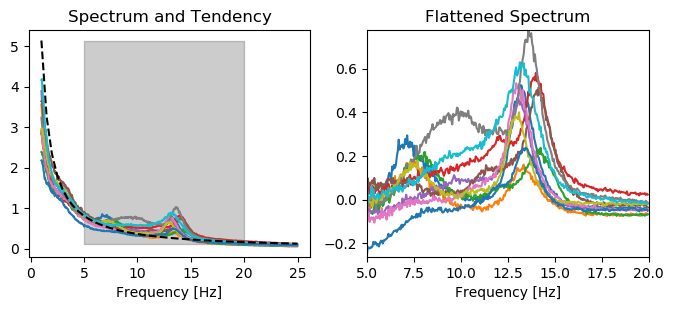

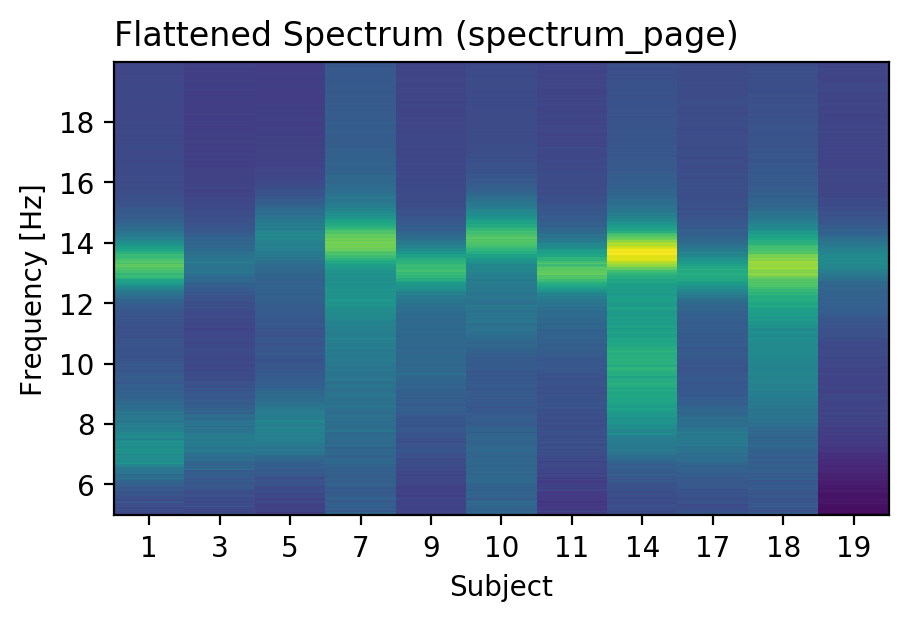

spectrum_window


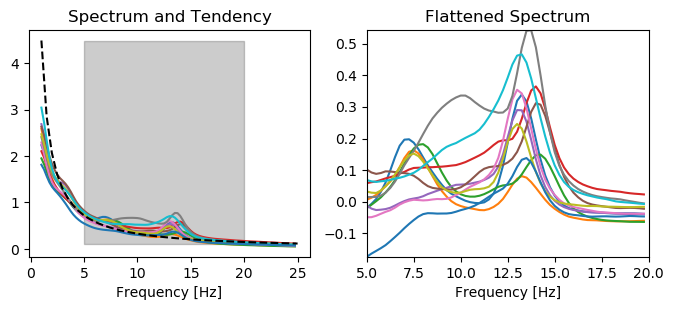

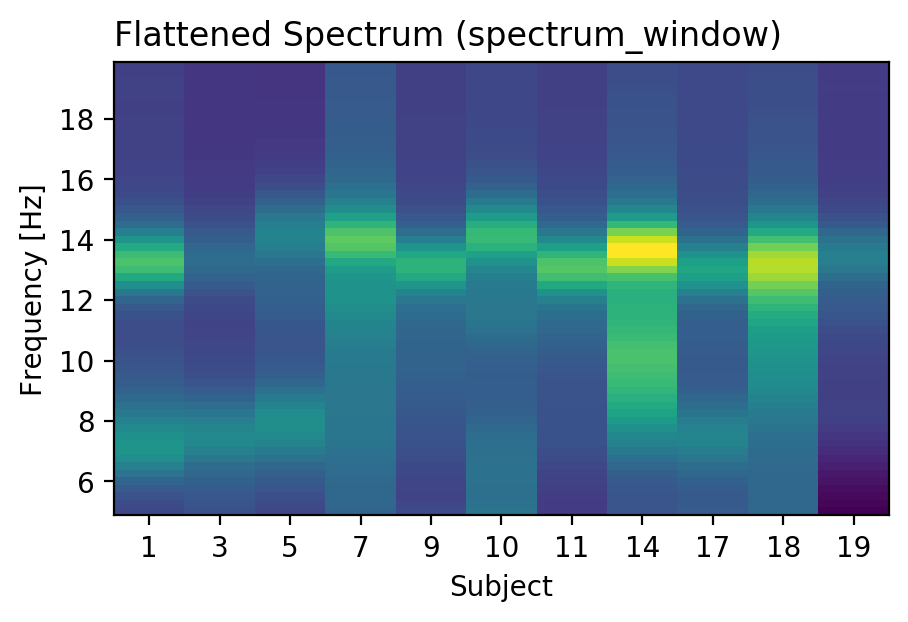

In [182]:
# chosen_key = 'spectrum_page'
for chosen_key in train_analysis[0].keys():
    print(chosen_key)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=100)
    # Find tendency
    ax = axes[0]
    coeffs = []
    first_freq = 1
    last_freq = 25
    zoom_first_freq = 5
    zoom_last_freq = 20
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        ax.plot(freq, power)
        # Fit
        fit_x = np.log(freq)
        fit_y = np.log(power)
        coeff = np.polyfit(fit_x, fit_y, 1)
        coeffs.append(coeff)
    coeffs = np.stack(coeffs, axis=0).mean(axis=0)
    regr_freq = np.linspace(first_freq, last_freq)
    regr_power = np.exp(coeffs[1]) * (regr_freq ** coeffs[0])
    ax.plot(regr_freq, regr_power, '--k')
    ax.fill_between([zoom_first_freq, zoom_last_freq], regr_power.min(), regr_power.max(), alpha=0.2, color="k")
    ax.set_title("Spectrum and Tendency")
    ax.set_xlabel("Frequency [Hz]")
    # plt.show()

    ax = axes[1]
    # plot without tendency
    first_freq = zoom_first_freq
    last_freq = zoom_last_freq
    power_range = []
    subjects_spectrum = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        power_general = np.exp(coeffs[1]) * (freq ** coeffs[0])
        power_without_tendency = power - power_general
        power_range.extend([power_without_tendency.min(), power_without_tendency.max()])
        subjects_spectrum.append(
            np.stack([freq, power_without_tendency], axis=1)
        )
        ax.plot(freq, power_without_tendency)
    power_range = [np.min(power_range), np.max(power_range)]
    ax.set_xlim([5, 20])
    ax.set_ylim(power_range)
    ax.set_title("Flattened Spectrum")
    ax.set_xlabel("Frequency [Hz]")

    plt.show()


    fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum], axis=0)
    freq_axis = subjects_spectrum[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(spectrum_image.T, origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    ax.set_title("Flattened Spectrum (%s)" % chosen_key, loc="left")
    plt.show()